In [6]:
#importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sqlite3
import pickle

from sklearn.manifold import TSNE
import gensim

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split# for shufflr = false
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [9]:
#read the dataset
conn=sqlite3.connect('final.sqlite')
final=pd.read_sql_query("""select * from Reviews""",conn)
conn.close()
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,cleaned_text_nonstem,cleaned_summ_nonstem
0,158339,171676,B000PVVG3O,A2Z6GD6SGCJQYZ,J. Hruby,0,0,1,1331164800,Great stuff for hiking/backpacking! Here's a r...,"For backpacking, using the ""Pack it in, pack i...",backpack use pack pack leav trace frame mind a...,backpacking using pack pack leave trace frames...,great stuff hiking backpacking heres recipe
1,154483,167502,B001RDOVKE,A1ISRCMLBVFPA0,Bill Nesbit,4,4,1,1288310400,What a Treat!!,I was pleasantly surprised at how wonderful th...,pleasant surpris wonder quit honest best turtl...,pleasantly surprised wonderful quite honestly ...,treat
2,94670,102898,B000HZIB9A,A59HMW5T6TP,Angela A. Hooper,1,1,1,1206576000,Awesome Marinade!!!!!,This is the best marinade ever to put on chick...,best marinad ever put chicken unfortun absolut...,best marinade ever put chicken unfortunately a...,awesome marinade
3,343872,371996,B003LVWCTW,A13M50YKJGDVBG,"S. Glosson ""eyesgreen52""",0,0,1,1322179200,Warm Comfort food,Excellent and you can use chicken broth and ro...,excel use chicken broth rossiteri chicken inst...,excellent use chicken broth rossiterie chicken...,warm comfort food
4,163030,176755,B000YFDON6,A2GAI61W3WHRJY,C. G. Royal,2,3,1,1217376000,gum,Product arrived very quickly. Nice job. this...,product arriv quick nice job best cinnamon gum...,product arrived quickly nice job best cinnamon...,gum


In [4]:
#list of sent pickle file
with open('list_of_sent_for_input_to_w2v.pkl', 'rb') as pickle_file:
    list_of_sent = pickle.load(pickle_file)

In [5]:
#google W2V file
with open('google_word2vec_model.txt', 'rb') as pickle_file:
    google_w2v = pickle.load(pickle_file)

In [12]:
type(google_w2v)

dict

* function to find sent vectors

In [6]:
def calc_w2v(list_of_sent, w2v_model):
    '''This function takes in 2 parameters as follows:
       1. list_of_sent - This is the list of sentences/reviews for which sentence vetors are to be constructed
       2. w2v_model - This is the Word2Vec model which is trained on the working corpus - contains the word vectors
       
       Return Value:
       sent_vectors - This is a list of sentence/review vectors constructed by averaging the word vectors
    '''
    
    ## Initialize an empty list
    sent_vectors = []
    ## Consider one sentence/review at a time
    for sent in list_of_sent:
        ## Initialize sentence vector to 0
        sent_vec = np.zeros(300)
        ## Initialize count of words to 0
        cnt_words = 0
        ## Consider the words one by one
        for word in sent:
            try:
                ## Calculate the word vector using the W2V model
                vec = w2v_model[word]
                ## Add the word vector to the sentence vector (This is the numerator)
                sent_vec += vec
                ## Sum all the word counts (This is the denominator)
                cnt_words += 1
            except:
                pass
        ## Divide the numerator by the denominator to get the sentence vector
        sent_vec /= cnt_words
        ## Add the sentence vector in the final list
        sent_vectors.append(sent_vec)
    ## return the list of all the sentence vectors
    return sent_vectors

In [7]:
sent_vectors=calc_w2v(list_of_sent,google_w2v)

C:\Users\vipul\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [8]:
#saving the sent_vectors into pickle file
with open('avg_w2v.pkl','wb') as pickle_file:
    pickle.dump(sent_vectors,pickle_file)

In [10]:
#opening pickle file of sent vectors
with open('avg_w2v.pkl','rb') as pickle_file:
    sent_vectors = pickle.load(pickle_file)

In [11]:
type(sent_vectors)

list

In [12]:
x=np.array(sent_vectors)
df=pd.DataFrame(x) #creating a dataframe of sentvectors

In [13]:
df['time']=final['Time'].iloc[:30000] #sampling the dataset
df['score']=final['Score'].iloc[:30000]

In [14]:
df=df.dropna(axis =0 ) #removing all those rows which contains null values

In [15]:
df=df.sort_values(['time']) #sorting on time
print(df.shape)
df.head()

(29999, 302)


,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,time,score
8085,0.026636,0.020126,-0.100281,0.082568,-0.080322,0.032446,0.111238,-0.064941,-0.004712,0.031787,...,-0.117480,0.041696,-0.019724,-0.000677,0.054999,-0.003418,-0.005280,-0.034076,9.440928e+08,1.0
7848,0.035762,-0.018346,0.014519,0.096415,-0.047579,0.013077,0.025580,-0.042450,0.081202,0.038269,...,-0.087121,-0.020732,-0.072937,-0.077292,0.015155,-0.045308,0.004209,-0.009718,1.014163e+09,1.0
14778,0.025155,0.032939,-0.018029,0.070336,-0.002390,-0.016184,0.021255,-0.089542,0.044086,0.068181,...,-0.056333,0.005591,-0.033571,-0.033758,0.003559,-0.043300,-0.011321,-0.004432,1.015546e+09,1.0
15230,0.015671,0.011968,0.012809,0.063908,-0.002440,0.020823,0.046337,-0.084791,0.037766,0.097527,...,-0.141511,-0.007959,-0.057002,-0.053705,0.054711,-0.065715,0.023933,-0.017054,1.022112e+09,1.0
18325,0.024051,-0.004985,-0.029165,0.154642,-0.004866,0.010529,0.016232,-0.078159,0.062291,0.064997,...,-0.120103,-0.007267,-0.002536,-0.048984,0.028034,-0.030596,0.021179,0.006236,1.025482e+09,1.0


In [16]:
x=df.iloc[:,:300].values #considering only first 300 features
print(type(x))
y=df['score'].values
type(y)

<class 'numpy.ndarray'>


numpy.ndarray

In [17]:
s=StandardScaler()
x=s.fit_transform(x)
x[:5,:]

array([[ 0.44478113, -0.43810809, -2.44299113, ...,  0.36107542,
        -0.89602902, -0.69066428],
       [ 0.68642813, -1.4540854 ,  0.52434386, ..., -0.66236256,
        -0.64302423, -0.05841649],
       [ 0.40558461, -0.09974699, -0.31695931, ..., -0.61329256,
        -1.05712918,  0.07878012],
       [ 0.15443302, -0.65354281,  0.48015774, ..., -1.16092899,
        -0.11707808, -0.24883401],
       [ 0.37634713, -1.10124109, -0.60479797, ..., -0.30290953,
        -0.19051796,  0.35569874]])

In [ ]:
#train-test split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.35,shuffle =False) #false since it is time series data

* Code to perform k fold

the optimal value of k is 11


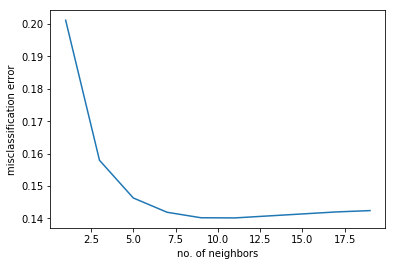

In [19]:
neighbors=list(range(1,21,2))
cv_scores=[]

for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k)
    score=cross_val_score(knn,x_train,y_train,cv=5,scoring='accuracy') #Hyper parameter -CV
    cv_scores.append(score.mean())
    
MSE=[1-x for x in cv_scores]

optimal_k=neighbors[MSE.index(min(MSE))]
print('the optimal value of k is %d' % optimal_k)
plt.plot(neighbors,MSE)
plt.xlabel('no. of neighbors')
plt.ylabel('misclassification error')
plt.show()

In [20]:
#fitting the model on optimal value of k
classifier = KNeighborsClassifier(n_neighbors = optimal_k)
classifier.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')

In [21]:
#generating prediction
y_pred = classifier.predict(x_test) 

In [22]:
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
acc

83.142857142857139

In [23]:
results = confusion_matrix(y_test, y_pred).T
print(results)

[[ 104   37]
 [1733 8626]]
